In [1]:
import pandas as pd
from Func_extr import *
from Func_viz import *
from Func_analisis  import *         

In [2]:
pixel = 195

mapRep_coper(pixel)

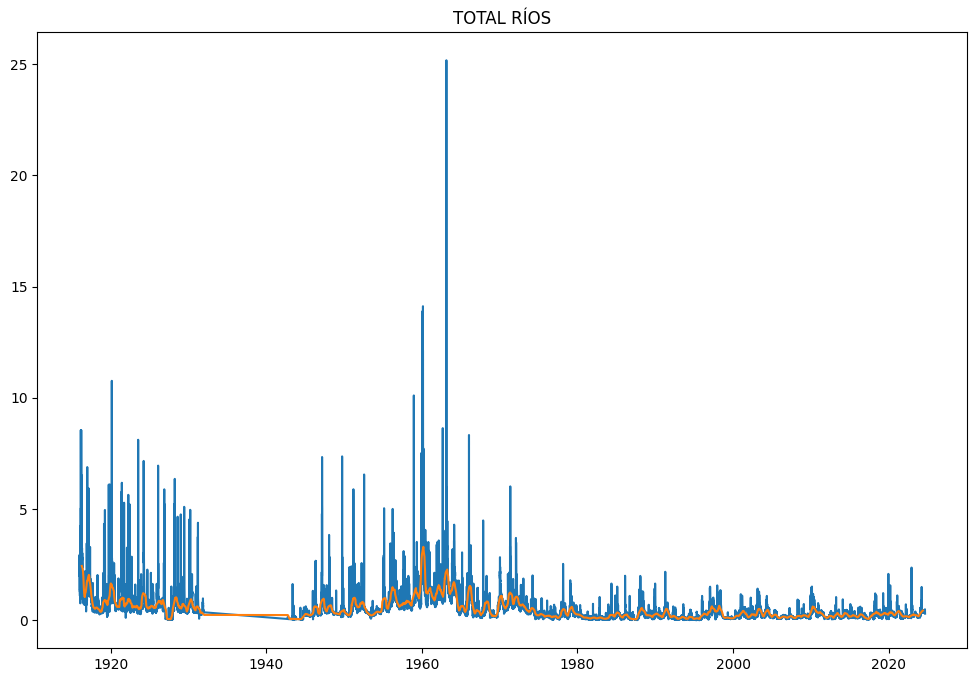

In [3]:
hist_evAgua (pixel, soloAgregados = True)

In [4]:
df_embalses, df_rios, df_c, df_aemet = dataExtract(pixel, x = True)

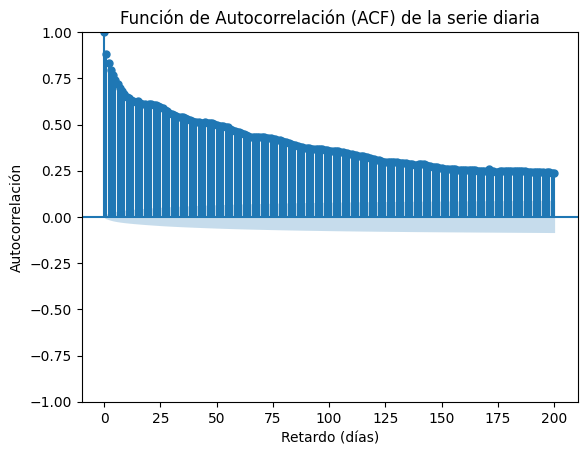

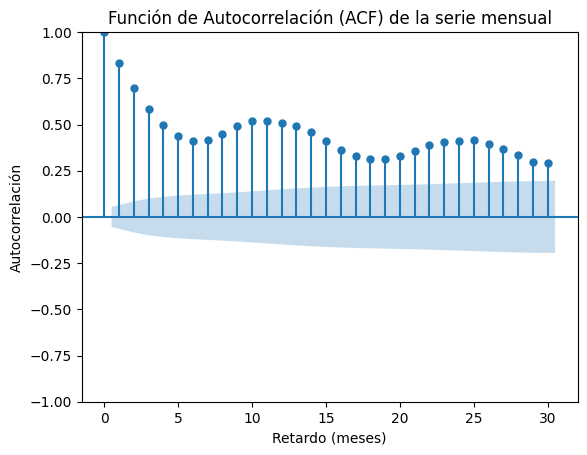

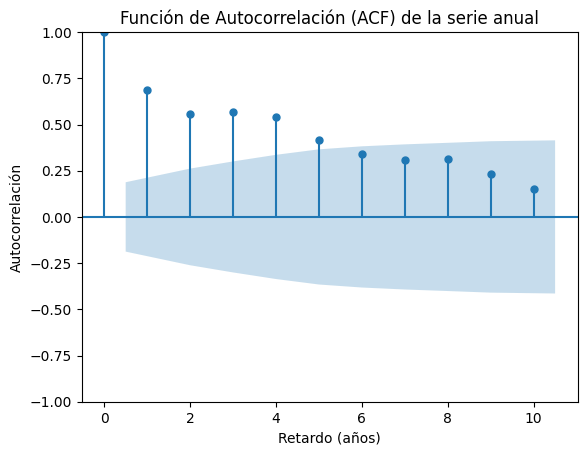

In [5]:
df_rios = df_rios.groupby('date').mean().reset_index()
autocorr_serie (df_rios, ['quantity_hm3'], lags_list = [200,30,10])

In [6]:
df = create_df(pixel)
##Retardos tiempo natural
variables = ['total_precipitation','evaporation','skin_temperature']
df = retardAvg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
df = retardAgg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
#retardos tiempo dinámico
df = df.sort_values('date').set_index('date')
#df = retardAvg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
#df = retardAgg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
df = df.select_dtypes(exclude=['datetime64'])
correlaciones = df.corr()
quantity_hm3_corr = correlaciones['quantity_hm3'].reset_index()
masCorreladasAgua = quantity_hm3_corr[abs(quantity_hm3_corr['quantity_hm3']) >0.1]['index'].to_list()
print(quantity_hm3_corr[(quantity_hm3_corr['quantity_hm3']) >0.2].sort_values('quantity_hm3', ascending = False) )
print(quantity_hm3_corr[(quantity_hm3_corr['quantity_hm3']) <-0.2].sort_values('quantity_hm3', ascending = True) )

                               index  quantity_hm3
8                       quantity_hm3      1.000000
7                         soil_water      0.416303
24   total_precipitation_mean_last4M      0.279694
69    total_precipitation_sum_last4M      0.278826
70    total_precipitation_sum_last6M      0.277403
25   total_precipitation_mean_last6M      0.276588
41   total_precipitation_mean_last3Y      0.262354
86    total_precipitation_sum_last3Y      0.262155
23   total_precipitation_mean_last3M      0.261141
71    total_precipitation_sum_last8M      0.260282
68    total_precipitation_sum_last3M      0.259874
26   total_precipitation_mean_last8M      0.259043
40   total_precipitation_mean_last2Y      0.242455
85    total_precipitation_sum_last2Y      0.242093
39   total_precipitation_mean_last1Y      0.235694
22   total_precipitation_mean_last2M      0.235216
84    total_precipitation_sum_last1Y      0.235182
42   total_precipitation_mean_last4Y      0.233514
87    total_precipitation_sum_l

### PCA

In [7]:
pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)

In [8]:
df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')

In [9]:
df_PCA_quant.corr()['quantity_hm3']


quantity_hm3                       1.000000
total_precipitation_PCA_D_comp1    0.237179
total_precipitation_PCA_D_comp2   -0.006706
total_precipitation_PCA_M_comp1    0.158721
total_precipitation_PCA_M_comp2    0.103910
total_precipitation_PCA_M_comp3    0.009886
total_precipitation_PCA_Y_comp1    0.351324
total_precipitation_PCA_Y_comp2    0.295807
total_precipitation_PCA_Y_comp3   -0.187023
evaporation_PCA_D_comp1            0.136972
evaporation_PCA_M_comp1           -0.018035
evaporation_PCA_M_comp2            0.062057
evaporation_PCA_Y_comp1            0.229623
evaporation_PCA_Y_comp2            0.352434
skin_temperature_PCA_D_comp1       0.138033
skin_temperature_PCA_D_comp2       0.045378
skin_temperature_PCA_M_comp1       0.496963
skin_temperature_PCA_M_comp2       0.085918
skin_temperature_PCA_M_comp3       0.115082
skin_temperature_PCA_Y_comp1       0.539451
skin_temperature_PCA_Y_comp2      -0.081596
skin_temperature_PCA_Y_comp3      -0.233397
Name: quantity_hm3, dtype: float

### Predicciones

#### Random Forests

In [12]:
from sklearn.metrics import r2_score

In [12]:
df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')
X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelo de Random Forest
rf_agua = RandomForestRegressor(
    n_estimators=40,          # Cantida de árboles para capturar patrones
    max_depth=20,            # Límite de profundidad
    min_samples_split=20,       # Divisiones 
    min_samples_leaf=15,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # 
)

# Entrenar en todos los datos
rf_agua.fit(X_train, y_train)

# Predicciones
y_train_pred = rf_agua.predict(X_train)
y_test_pred = rf_agua.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"R^2 en entrenamiento: {train_r2:.4f}")
print(f"R^2 en test: {test_r2:.4f}")




# Importancia de las características
#feature_importances = pd.DataFrame({
 #   'Feature': X.columns,
  #  'Importance': rf.feature_importances_
#}).sort_values(by='Importance', ascending=False)

R^2 en entrenamiento: 0.8130
R^2 en test: 0.8251


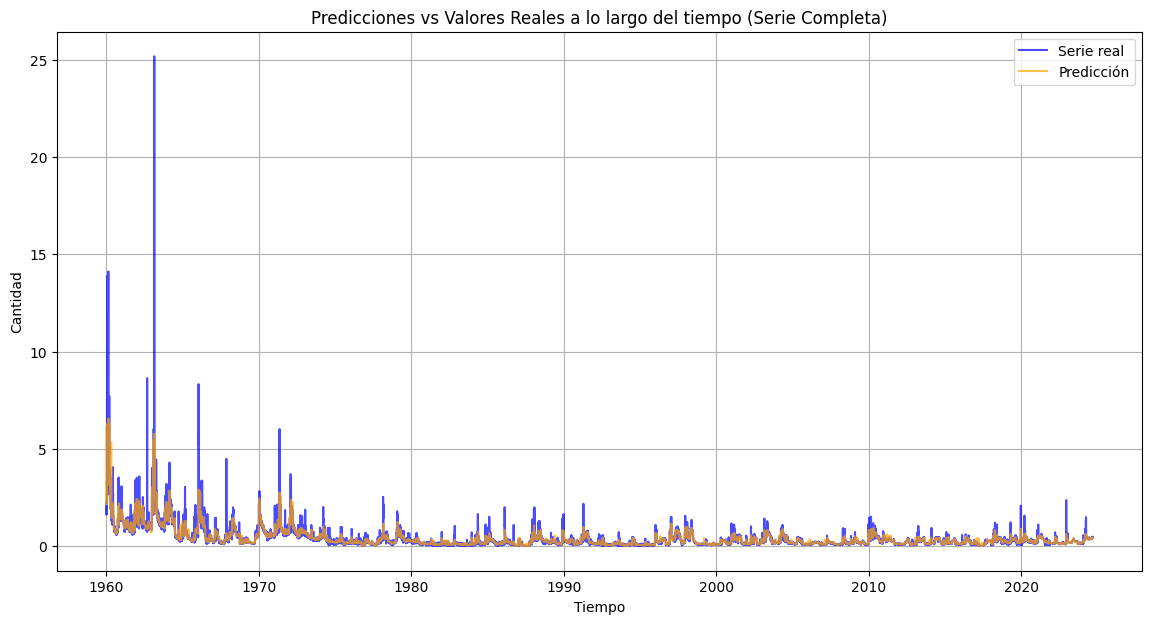

In [13]:
y_predict_train = pd.Series(y_train_pred)
y_predict_test = pd.Series(y_test_pred)

y_predict = pd.concat([y_predict_train, y_predict_test])
y_predict = y_predict.reset_index()[0]
y = pd.concat([y_train, y_test]).reset_index()
x = pd.concat([X_train, X_test])
df_merge = pd.merge(y,x, on ='date')

df_merge['quantity_hm3_predict'] = y_predict
df_merge.sort_values('date',inplace = True)
df_merge.set_index('date', inplace = True)
plt.figure(figsize=(14, 7))
plt.plot(df_merge['quantity_hm3'], label = 'Serie real', color='blue', alpha=0.7 )
plt.plot(df_merge['quantity_hm3_predict'] , label = 'Predicción', color='orange', alpha=0.7)
plt.title('Predicciones vs Valores Reales a lo largo del tiempo (Serie Completa)')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.grid(True)
plt.legend()
plt.show()

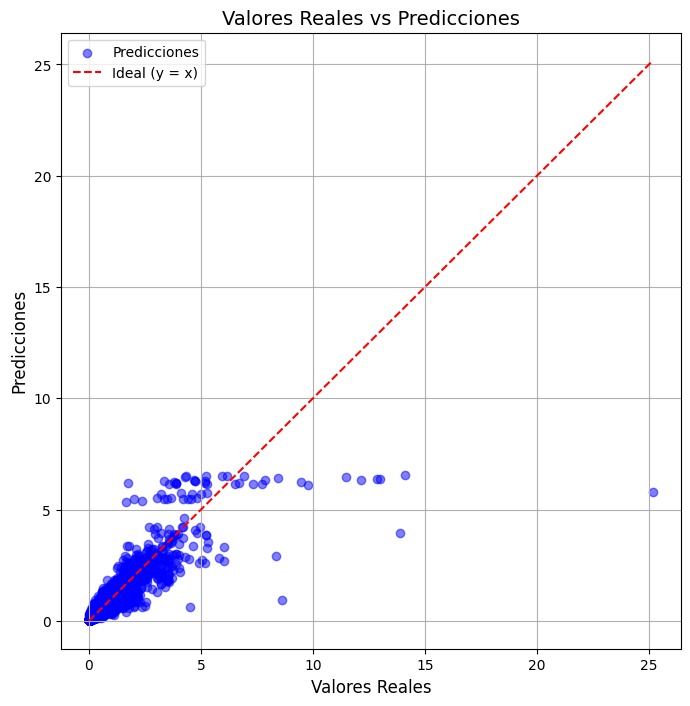

In [14]:
# Crear la gráfica de dispersión
plt.figure(figsize=(8, 8))
plt.scatter(df_merge['quantity_hm3'], df_merge['quantity_hm3_predict'], alpha=0.5, color='blue', label='Predicciones')
plt.plot([min(df_merge['quantity_hm3']), max(df_merge['quantity_hm3'])], [min(df_merge['quantity_hm3']), max(df_merge['quantity_hm3'])], color='red', linestyle='--', label='Ideal (y = x)')

# Etiquetas y título
plt.xlabel('Valores Reales', fontsize=12)
plt.ylabel('Predicciones', fontsize=12)
plt.title('Valores Reales vs Predicciones', fontsize=14)
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [41]:
feature_importances[feature_importances['Importance']>0.01]

,Feature,Importance
20,skin_temperature_PCA_Y_comp1,0.212531
12,evaporation_PCA_Y_comp2,0.160435
9,evaporation_PCA_M_comp1,0.148934
11,evaporation_PCA_Y_comp1,0.081912
2,total_precipitation_PCA_M_comp1,0.051924
14,skin_temperature_PCA_D_comp1,0.050606
0,total_precipitation_PCA_D_comp1,0.048769
16,skin_temperature_PCA_M_comp1,0.046106
19,skin_temperature_PCA_M_comp4,0.030369
3,total_precipitation_PCA_M_comp2,0.027894


### Optimizción del modelo

### Maximizar horizonte temporal 

In [10]:
retardos_dict = {}

for day in range(1825):
    retardos_dict[day] = {}
    dias_iniciales = [1,2,3,4,5,6,7,15,20]
    dias_retardos = [i+day for i in dias_iniciales]
    retardos_dict[day]['D'] = dias_retardos
    meses_iniciales = [1,2,3,4,6,8,9,10,11,12]
    mes = min(day // 30, len(meses_iniciales))
    meses_retardos = [i+mes for i in meses_iniciales]
    retardos_dict[day]['M'] = meses_retardos
    años_iniciales = [1,2,3,4,5]
    año = min(day // 365, len(años_iniciales)) 
    años_retardos = [i+año for i in años_iniciales]
    retardos_dict[day]['Y'] = años_retardos


In [382]:
R_2_train_list = []
R_2_test_list = []

for key,value in retardos_dict.items():
    print('Calculando para ',value['D'][0], 'retardos mínimos...')
    df = create_df(pixel)
    ##Retardos tiempo natural
    day_lags = value['D']
    month_lags = value['M']
    year_lags = value['Y']
    variables = ['total_precipitation','evaporation','skin_temperature']
    df = retardAvg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
    df = retardAvg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
    df = retardAvg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
    df = retardAgg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
    df = retardAgg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
    df = retardAgg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
    #retardos tiempo dinámico
    df = df.sort_values('date').set_index('date')
    #df = retardAvg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
    #df = retardAgg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
    df = df.select_dtypes(exclude=['datetime64'])
    
    pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)
    
    df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')
    
    X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
    y = df_PCA_quant['quantity_hm3']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # Modelo de Random Forest
    rf_agua = RandomForestRegressor(
        n_estimators=40,          # Cantida de árboles para capturar patrones
        max_depth=20,            # Límite de profundidad
        min_samples_split=20,       # Divisiones 
        min_samples_leaf=15,        # Permite hojas pequeñas
        random_state=42,           # Reproducibilidad
        bootstrap=True            # 
    )
    
    # Entrenar en todos los datos
    rf_agua.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = rf_agua.predict(X_train)
    y_test_pred = rf_agua.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    R_2_train_list.append(train_r2)
    R_2_test_list.append(test_r2)



Calculando para  1 retardos mínimos...
Calculando para  2 retardos mínimos...
Calculando para  3 retardos mínimos...
Calculando para  4 retardos mínimos...
Calculando para  5 retardos mínimos...
Calculando para  6 retardos mínimos...
Calculando para  7 retardos mínimos...
Calculando para  8 retardos mínimos...
Calculando para  9 retardos mínimos...
Calculando para  10 retardos mínimos...
Calculando para  11 retardos mínimos...
Calculando para  12 retardos mínimos...
Calculando para  13 retardos mínimos...
Calculando para  14 retardos mínimos...
Calculando para  15 retardos mínimos...
Calculando para  16 retardos mínimos...
Calculando para  17 retardos mínimos...
Calculando para  18 retardos mínimos...
Calculando para  19 retardos mínimos...
Calculando para  20 retardos mínimos...
Calculando para  21 retardos mínimos...
Calculando para  22 retardos mínimos...
Calculando para  23 retardos mínimos...
Calculando para  24 retardos mínimos...
Calculando para  25 retardos mínimos...
Calculand

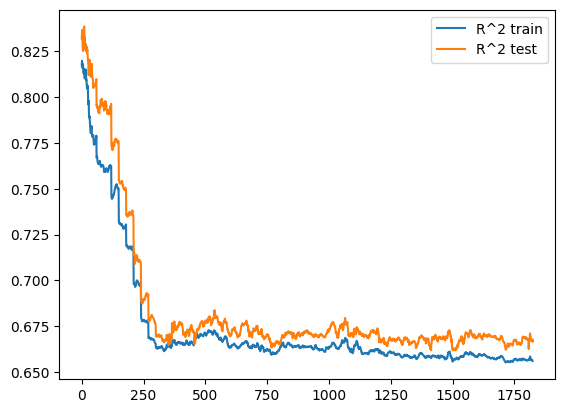

In [384]:
plt.plot(R_2_train_list, label = 'R^2 train')
plt.plot(R_2_test_list, label = 'R^2 test')
plt.legend()
plt.show()

In [391]:
df_r2 = pd.DataFrame({
    'Retardo': list(range(len(retardos_dict))),
    'R_2_train_list': R_2_train_list,
    'R_2_test_list': R_2_test_list
})

In [393]:
df_r2.to_csv('r2_retardos')

In [416]:
R_2_train_list[200]

0.7176409065805809

### Buscamos el mejor modelo

In [ ]:
from sklearn.model_selection import GridSearchCV

df = create_df(pixel)
##Retardos tiempo natural
day_lags = retardos_dict[retardosMax]['D']
month_lags = retardos_dict[retardosMax]['M']
year_lags = retardos_dict[retardosMax]['Y']
variables = ['total_precipitation','evaporation','skin_temperature']
df = retardAvg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
df = retardAvg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
df = retardAvg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
df = retardAgg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
df = retardAgg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
df = retardAgg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
#retardos tiempo dinámico
df = df.sort_values('date').set_index('date')
df = df.select_dtypes(exclude=['datetime64'])

pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)

df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')

X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'bootstrap': [True, False],  # Usar muestras bootstrap
}
# Crear el modelo Random Forest
rf_agua = RandomForestRegressor(random_state=42)

# Definir la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf_agua, param_grid=param_grid, 
                           cv=5,  # 5 pliegues para la validación cruzada
                           n_jobs=-1,  # Utiliza todos los núcleos disponibles
                           verbose=2,  # Muestra el progreso de la búsqueda
                           scoring='neg_mean_squared_error')  # Usar el error cuadrático medio negativo como métrica

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Ver el mejor conjunto de hiperparámetros
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Mejor modelo
best_rf = grid_search.best_estimator_

ERROR! Session/line number was not unique in database. History logging moved to new session 620
Fitting 5 folds for each of 162 candidates, totalling 810 fits


### Predicción a 100 días

In [66]:
retardosMax = 50

##### Reentrenamos modelo

In [67]:
df = create_df(pixel)
##Retardos tiempo natural
day_lags = retardos_dict[retardosMax]['D']
month_lags = retardos_dict[retardosMax]['M']
year_lags = retardos_dict[retardosMax]['Y']
variables = ['total_precipitation', 'skin_temperature', 'evaporation', 'runoff',
       'snowfall', 'high_vegetation_cover', 'low_vegetation_cover',
       'soil_water']
df = retardAvg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
df = retardAvg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
df = retardAvg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
df = retardAgg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
df = retardAgg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
df = retardAgg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
#retardos tiempo dinámico
df = df.sort_values('date').set_index('date')
#df = retardAvg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
#df = retardAgg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
df = df.select_dtypes(exclude=['datetime64'])

pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)

df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')

X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelo de Random Forest
rf_agua = RandomForestRegressor(
    n_estimators=40,          # Cantida de árboles para capturar patrones
    max_depth=20,            # Límite de profundidad
    min_samples_split=20,       # Divisiones 
    min_samples_leaf=15,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # 
)

# Entrenar en todos los datos
rf_agua.fit(X_train, y_train)

# Predicciones
y_train_pred = rf_agua.predict(X_train)
y_test_pred = rf_agua.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(train_r2)
print(test_r2)

0.7649579515763915
0.7927367405565601


##### Hacemos predicción

In [68]:
df2 = create_df(pixel).reset_index().sort_values('date')
#df2 = df2[df2['date'].dt.year < 2024]

fecha_inicial  = df2['date'].max() 
fecha_final = df2['date'].max() + pd.Timedelta(days=retardosMax) 
df_date_range = pd.DataFrame(pd.date_range(start=fecha_inicial, end=fecha_final, freq='D'), columns=['date'])

df_new = pd.merge(df_date_range, df2, on='date', how='outer').sort_values('date').set_index('date')

day_lags = retardos_dict[retardosMax]['D']
month_lags = retardos_dict[retardosMax]['M']
year_lags = retardos_dict[retardosMax]['Y']
#variables = ['total_precipitation','evaporation','skin_temperature']
df_new = retardAvg_tNat(df_new, vars = variables, lags = day_lags, frec = 'D')
df_new = retardAvg_tNat(df_new, vars = variables, lags = month_lags, frec = 'M')
df_new = retardAvg_tNat(df_new, vars = variables, lags = year_lags, frec = 'Y')
df_new = retardAgg_tNat(df_new, vars = variables, lags = day_lags, frec = 'D')
df_new = retardAgg_tNat(df_new, vars = variables, lags = month_lags, frec = 'M')
df_new = retardAgg_tNat(df_new, vars = variables, lags = year_lags, frec = 'Y')
df_new = df_new.sort_values('date').set_index('date')
df_new = df_new.select_dtypes(exclude=['datetime64'])


n_components_dict = extract_n_components(pca_df.drop('date',axis = 1).columns)
pca_df_new = process_pca_custom_components(df = df_new, variables = variables, frecuencias  = ['D', 'M', 'Y'], n_components_dict = n_components_dict, imprimir=False)

pca_df_new = pca_df_new[pca_df_new['date'] >= fecha_inicial].set_index('date')

y_new = rf_agua.predict(pca_df_new)

pca_df_new['quantity_hm3_pred'] = y_new

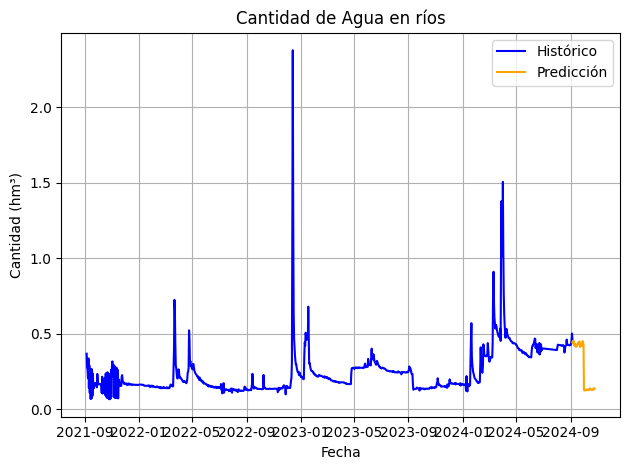

In [69]:
y1 = y.reset_index()

y2 = y1[y1['date'] > '2021-09-04']
y_pred = pca_df_new['quantity_hm3_pred'].reset_index()


# Gráfica de los datos de 'y'
plt.plot(y2['date'], y2['quantity_hm3'], label='Histórico', color='blue')

# Gráfica de los datos de 'df_predNew'
plt.plot(y_pred['date'], y_pred['quantity_hm3_pred'], label='Predicción', color='orange')

# Añadir títulos y etiquetas
plt.title('Cantidad de Agua en ríos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad (hm³)')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()
plt.show()


#### Validación datos nuevos

In [42]:
import requests
import zipfile
import io
import pandas as pd

# URL del archivo ZIP
url = "https://aps.chj.es/down/CSV/F2796_Rios_y_Canales_ROEA.zip"

# Paso 1: Descargar el archivo ZIP
response = requests.get(url)
response.raise_for_status()  # Verificar si la descarga fue exitosa

# Paso 2: Cargar el contenido del ZIP en memoria
zip_file = zipfile.ZipFile(io.BytesIO(response.content))


# Paso 4: Leer el archivo "F2796_D2_Serie día.csv"
target_file = "F2796_D2_Serie día.csv"
if target_file in zip_file.namelist():
    with zip_file.open(target_file) as file:
        # Leer el archivo CSV directamente como DataFrame
        df_rios_canales = pd.read_csv(file, sep=";", encoding="latin1")  # Ajusta el separador y la codificación si es necesario

else:
    print(f"El archivo '{target_file}' no se encuentra en el ZIP.")
df_rios_canales = df_rios_canales.rename(columns = {'Cód. CHJ' : 'id_station','Fecha' : 'date','Cantidad (hm³)' : 'quantity_hm3'})
df_rios_canales = df_rios_canales[['id_station', 'date','quantity_hm3']]
df_rios_canales['date'] = pd.to_datetime(df_rios_canales['date'], format='%d-%m-%Y %H:%M:%S')
df_rios_canales = df_rios_canales.dropna()
df_rios_canales['quantity_hm3'] = df_rios_canales['quantity_hm3'].str.replace(',','.').astype('float')
id_stations = extract_infos (pixel)['id_station_rios_canales'].to_list()
df_rios_canales = df_rios_canales[df_rios_canales['id_station'].isin(id_stations)].groupby('date').mean()['quantity_hm3']
df_rios_canales = df_rios_canales.reset_index()
df_rios_canales_valid = df_rios_canales[df_rios_canales['date'] > '2024-09-05']

Lo juntamos con la prediccion a 100 días

In [70]:
df_validacion = pd.merge(y_pred,df_rios_canales_valid, on = 'date', how = 'inner').set_index('date')

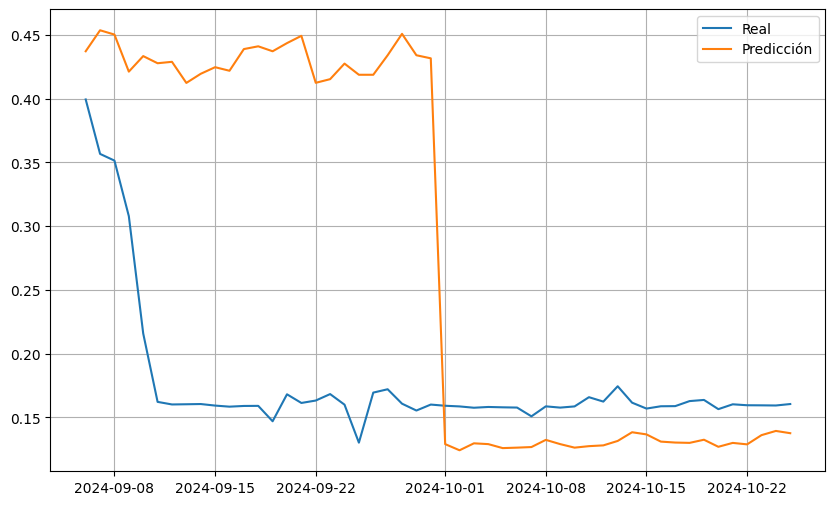

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(df_validacion['quantity_hm3'], label = 'Real')
plt.plot(df_validacion['quantity_hm3_pred'], label = 'Predicción')
plt.legend()
plt.grid()
plt.show()

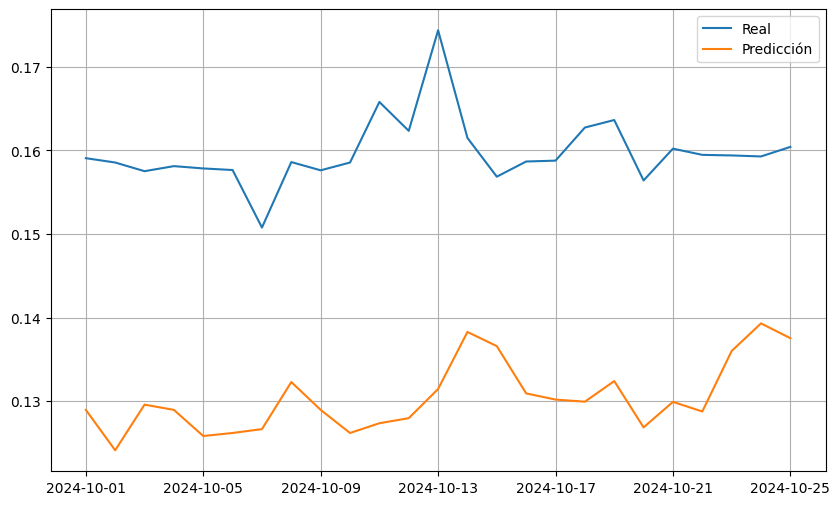

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(df_validacion['quantity_hm3'].iloc[25:], label = 'Real')
plt.plot(df_validacion['quantity_hm3_pred'].iloc[25:], label = 'Predicción')
plt.legend()
plt.grid()
plt.show()

In [73]:
np.mean(abs(df_validacion['quantity_hm3']-df_validacion['quantity_hm3_pred']))

0.1338273897864065

In [74]:
np.mean(abs(df_validacion['quantity_hm3'].iloc[25:]-df_validacion['quantity_hm3_pred'].iloc[25:]))

0.029298858673517277

#### Predicción a 1000 días

0.6593783736553243
0.6575320599636082


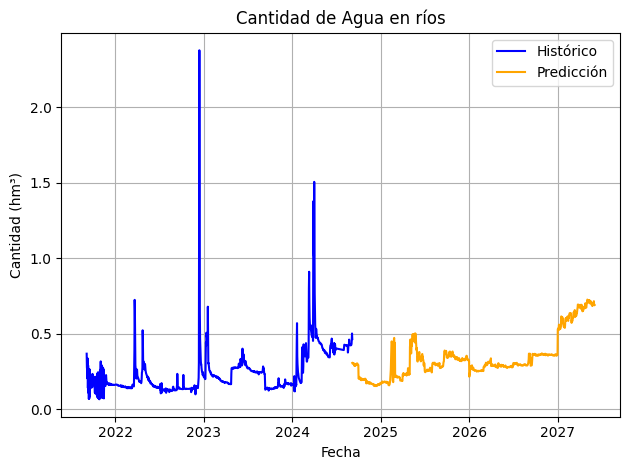

In [301]:
retardosMax = 1000

df = create_df(pixel)
##Retardos tiempo natural
day_lags = retardos_dict[retardosMax]['D']
month_lags = retardos_dict[retardosMax]['M']
year_lags = retardos_dict[retardosMax]['Y']
variables = ['total_precipitation','evaporation','skin_temperature']
df = retardAvg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
df = retardAvg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
df = retardAvg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
df = retardAgg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
df = retardAgg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
df = retardAgg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
#retardos tiempo dinámico
df = df.sort_values('date').set_index('date')
#df = retardAvg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
#df = retardAgg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
df = df.select_dtypes(exclude=['datetime64'])

pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)

df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')

X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelo de Random Forest
rf_agua = RandomForestRegressor(
    n_estimators=40,          # Cantida de árboles para capturar patrones
    max_depth=20,            # Límite de profundidad
    min_samples_split=20,       # Divisiones 
    min_samples_leaf=15,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # 
)

# Entrenar en todos los datos
rf_agua.fit(X_train, y_train)

# Predicciones
y_train_pred = rf_agua.predict(X_train)
y_test_pred = rf_agua.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(train_r2)
print(test_r2)

df2 = create_df(pixel).reset_index().sort_values('date')
#df2 = df2[df2['date'].dt.year < 2024]

fecha_inicial  = df2['date'].max() 
fecha_final = df2['date'].max() + pd.Timedelta(days=retardosMax) 
df_date_range = pd.DataFrame(pd.date_range(start=fecha_inicial, end=fecha_final, freq='D'), columns=['date'])

df_new = pd.merge(df_date_range, df2, on='date', how='outer').sort_values('date').set_index('date')

day_lags = retardos_dict[retardosMax]['D']
month_lags = retardos_dict[retardosMax]['M']
year_lags = retardos_dict[retardosMax]['Y']
variables = ['total_precipitation','evaporation','skin_temperature']
df_new = retardAvg_tNat(df_new, vars = variables, lags = day_lags, frec = 'D')
df_new = retardAvg_tNat(df_new, vars = variables, lags = month_lags, frec = 'M')
df_new = retardAvg_tNat(df_new, vars = variables, lags = year_lags, frec = 'Y')
df_new = retardAgg_tNat(df_new, vars = variables, lags = day_lags, frec = 'D')
df_new = retardAgg_tNat(df_new, vars = variables, lags = month_lags, frec = 'M')
df_new = retardAgg_tNat(df_new, vars = variables, lags = year_lags, frec = 'Y')
df_new = df_new.sort_values('date').set_index('date')
df_new = df_new.select_dtypes(exclude=['datetime64'])


n_components_dict = extract_n_components(pca_df.drop('date',axis = 1).columns)
pca_df_new = process_pca_custom_components(df = df_new, variables = variables, frecuencias  = ['D', 'M', 'Y'], n_components_dict = n_components_dict, imprimir=False)

pca_df_new = pca_df_new[pca_df_new['date'] >= fecha_inicial].set_index('date')

y_new = rf_agua.predict(pca_df_new)

pca_df_new['quantity_hm3_pred'] = y_new

y1 = y.reset_index()

y2 = y1[y1['date'] > '2021-09-04']
y_pred = pca_df_new['quantity_hm3_pred'].reset_index()


# Gráfica de los datos de 'y'
plt.plot(y2['date'], y2['quantity_hm3'], label='Histórico', color='blue')

# Gráfica de los datos de 'df_predNew'
plt.plot(y_pred['date'], y_pred['quantity_hm3_pred'], label='Predicción', color='orange')

# Añadir títulos y etiquetas
plt.title('Cantidad de Agua en ríos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad (hm³)')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()
plt.show()


#### Distintos escenarios:

In [259]:
retardosMax = 200
# Configuración base
base_params = {
    'n_estimators': 40,
    'max_depth': 20,
    'min_samples_split': 20,
    'min_samples_leaf': 15,
    'random_state': 42,
    'bootstrap': True
}

# Escenarios de hiperparámetros
hiperparametros_escenarios = {
    "escenario_1": {**base_params, 'n_estimators': 50},
    "escenario_2": {**base_params, 'max_depth': 25},
    "escenario_3": {**base_params, 'min_samples_split': 10},
    "escenario_4": {**base_params, 'min_samples_leaf': 5},
    "escenario_5": {**base_params, 'random_state': 100},  # Cambiar semilla
    "escenario_6": {**base_params, 'n_estimators': 60, 'max_depth': 15},
    "escenario_7": {**base_params, 'n_estimators': 30, 'bootstrap': False},
    "escenario_8": {**base_params, 'max_depth': None, 'min_samples_split': 5},
    "escenario_9": {**base_params, 'min_samples_leaf': 10, 'random_state': 0},
    "escenario_10": {**base_params, 'n_estimators': 100, 'min_samples_split': 2}
}

resultados = []
# Imprimir para verificar configuraciones
for nombre, params in hiperparametros_escenarios.items():
    print(f"{nombre}: {params}")
    df = create_df(pixel)
    ##Retardos tiempo natural
    day_lags = retardos_dict[retardosMax]['D']
    month_lags = retardos_dict[retardosMax]['M']
    year_lags = retardos_dict[retardosMax]['Y']
    variables = ['total_precipitation','evaporation','skin_temperature']
    df = retardAvg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
    df = retardAvg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
    df = retardAvg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
    df = retardAgg_tNat(df, vars = variables, lags = day_lags, frec = 'D')
    df = retardAgg_tNat(df, vars = variables, lags = month_lags, frec = 'M')
    df = retardAgg_tNat(df, vars = variables, lags = year_lags, frec = 'Y')
    #retardos tiempo dinámico
    df = df.sort_values('date').set_index('date')
    #df = retardAvg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
    #df = retardAgg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
    df = df.select_dtypes(exclude=['datetime64'])
    
    pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)
    
    df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')
    
    X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
    y = df_PCA_quant['quantity_hm3']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # Modelo de Random Forest
    rf_agua = RandomForestRegressor(**params)
    
    # Entrenar en todos los datos
    rf_agua.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = rf_agua.predict(X_train)
    y_test_pred = rf_agua.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print('R^2 train: ',train_r2, '\nR^2 test: ',test_r2)
    
    df2 = create_df(pixel).reset_index().sort_values('date')
    #df2 = df2[df2['date'].dt.year < 2024]
    
    fecha_inicial  = df2['date'].max() 
    fecha_final = df2['date'].max() + pd.Timedelta(days=retardosMax) 
    df_date_range = pd.DataFrame(pd.date_range(start=fecha_inicial, end=fecha_final, freq='D'), columns=['date'])
    
    df_new = pd.merge(df_date_range, df2, on='date', how='outer').sort_values('date').set_index('date')
    
    day_lags = retardos_dict[retardosMax]['D']
    month_lags = retardos_dict[retardosMax]['M']
    year_lags = retardos_dict[retardosMax]['Y']
    variables = ['total_precipitation','evaporation','skin_temperature']
    df_new = retardAvg_tNat(df_new, vars = variables, lags = day_lags, frec = 'D')
    df_new = retardAvg_tNat(df_new, vars = variables, lags = month_lags, frec = 'M')
    df_new = retardAvg_tNat(df_new, vars = variables, lags = year_lags, frec = 'Y')
    df_new = retardAgg_tNat(df_new, vars = variables, lags = day_lags, frec = 'D')
    df_new = retardAgg_tNat(df_new, vars = variables, lags = month_lags, frec = 'M')
    df_new = retardAgg_tNat(df_new, vars = variables, lags = year_lags, frec = 'Y')
    df_new = df_new.sort_values('date').set_index('date')
    df_new = df_new.select_dtypes(exclude=['datetime64'])
    
    
    n_components_dict = extract_n_components(pca_df.drop('date',axis = 1).columns)
    pca_df_new = process_pca_custom_components(df = df_new, variables = variables, frecuencias  = ['D', 'M', 'Y'], n_components_dict = n_components_dict, imprimir=False)
    
    pca_df_new = pca_df_new[pca_df_new['date'] >= fecha_inicial].set_index('date')
    
    y_new = rf_agua.predict(pca_df_new)
    resultados.append({
        "escenario": nombre,
        "predicciones": y_new
    })

escenario_1: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 15, 'random_state': 42, 'bootstrap': True}
R^2 train:  0.7022068172502924 
R^2 test:  0.7111309668646248
escenario_2: {'n_estimators': 40, 'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 15, 'random_state': 42, 'bootstrap': True}
R^2 train:  0.7025015921200963 
R^2 test:  0.710930498701724
escenario_3: {'n_estimators': 40, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 15, 'random_state': 42, 'bootstrap': True}
R^2 train:  0.7023776511833149 
R^2 test:  0.7108427005613377
escenario_4: {'n_estimators': 40, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 5, 'random_state': 42, 'bootstrap': True}
R^2 train:  0.7317642370161566 
R^2 test:  0.7253177910547564
escenario_5: {'n_estimators': 40, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 15, 'random_state': 100, 'bootstrap': True}
R^2 train:  0.7017668160657025 
R^2 test:  0.7093452435304

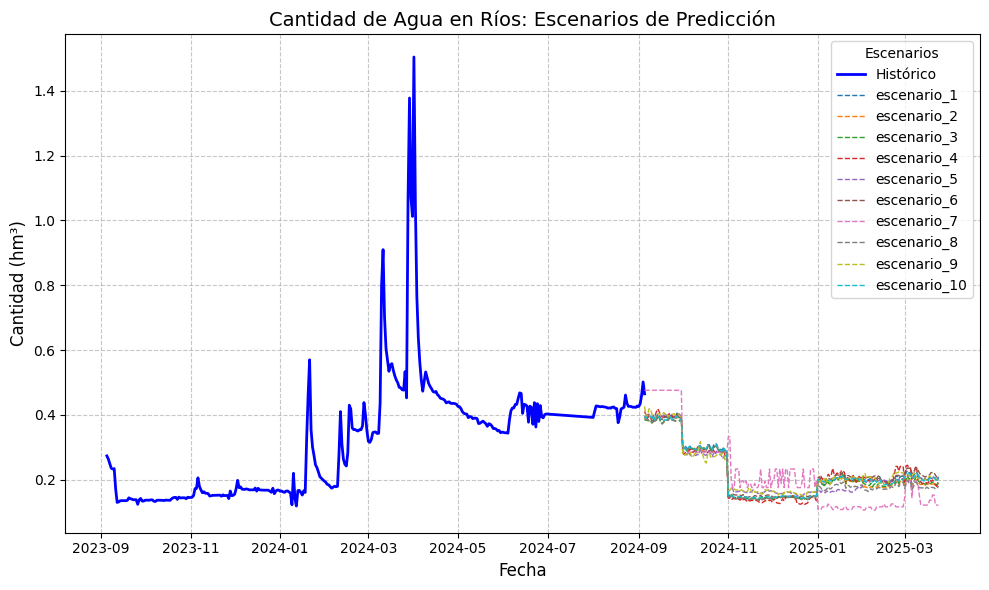

In [267]:
# Lista de escenarios con nombres
nombres_escenarios = [resultado["escenario"] for resultado in resultados]

# Gráfica del histórico
y1 = y.reset_index()
y2 = y1[y1['date'] > '2023-09-04']

plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.plot(y2['date'], y2['quantity_hm3'], label='Histórico', color='blue', linewidth=2)

# Graficar cada escenario
for i, resultado in enumerate(resultados):
    fechas = pca_df_new.reset_index()['date']
    y_pred = resultado["predicciones"]  # Predicciones del escenario
    plt.plot(
        fechas,  # Fechas para las predicciones (alineadas al histórico)
        y_pred, 
        label=nombres_escenarios[i], 
        linestyle='--', 
        linewidth=1
    )

# Añadir títulos y etiquetas
plt.title('Cantidad de Agua en Ríos: Escenarios de Predicción', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad (hm³)', fontsize=12)
plt.legend(title='Escenarios', fontsize=10)

# Añadir grid y ajustar diseño
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## Borrador

#### Regresion lineal

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Regresión Lineal
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(X_train, y_train)

# Predicciones
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Métricas de evaluación
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"R^2 en entrenamiento: {train_r2:.4f}")
print(f"R^2 en test: {test_r2:.4f}")
print(f"RMSE en entrenamiento: {train_rmse:.4f}")
print(f"RMSE en test: {test_rmse:.4f}")

R^2 en entrenamiento: 0.5472
R^2 en test: 0.5617
RMSE en entrenamiento: 0.3861
RMSE en test: 0.3729


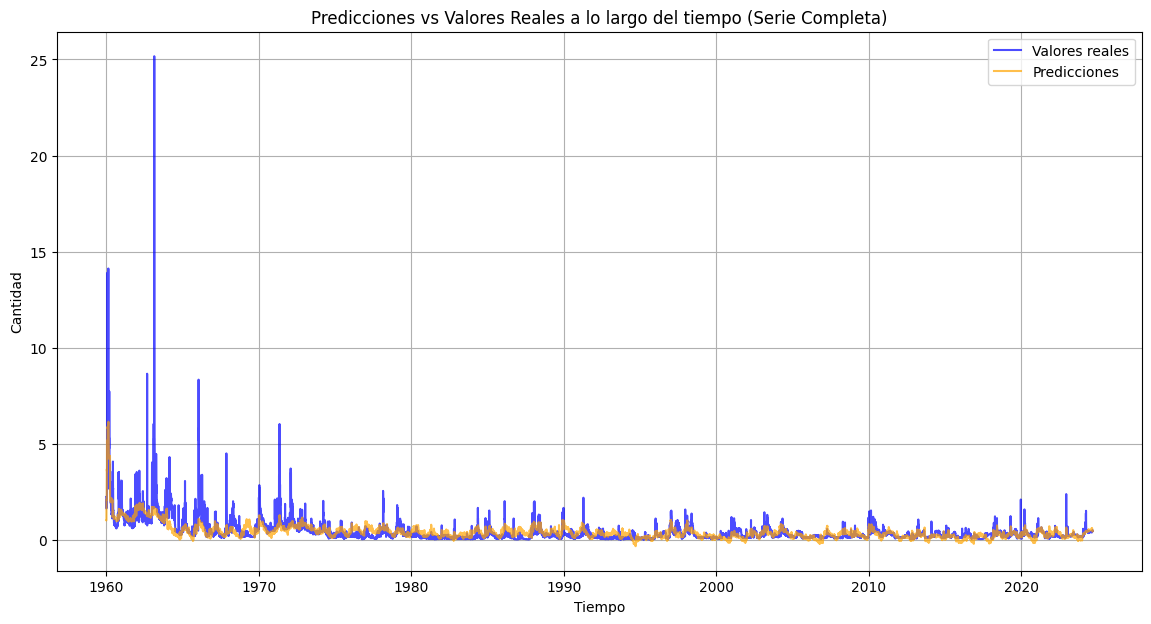

In [13]:
# Concatenar datos de entrenamiento y prueba
y_all = pd.concat([y_train, y_test])
y_pred_all = pd.concat([pd.Series(y_train_pred, index=y_train.index), pd.Series(y_test_pred, index=y_test.index)])

# Asegurarnos de que estén ordenados por tiempo
y_all = y_all.sort_index()
y_pred_all = y_pred_all.sort_index()

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(y_all.index, y_all, label='Valores reales', color='blue', alpha=0.7)
plt.plot(y_pred_all.index, y_pred_all, label='Predicciones', color='orange', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.title('Predicciones vs Valores Reales a lo largo del tiempo (Serie Completa)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
X = df_PCA_quant.drop('quantity_hm3', axis=1)
y = df_PCA_quant['quantity_hm3']

# Añadir una constante para el término independiente (intercepto)
X = sm.add_constant(X)

# Ajustar el modelo usando Statsmodels
model = sm.OLS(y, X)  # Ordinary Least Squares
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           quantity_hm3   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     1201.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:05:38   Log-Likelihood:                -10861.
No. Observations:               23594   AIC:                         2.177e+04
Df Residuals:                   23569   BIC:                         2.197e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

#### Proyecciones futuras

In [235]:
def modelo_caracteristicas (pixel, var_output):
    df = create_df(pixel)
    ##Retardos tiempo natural
    variables =  ['total_precipitation','evaporation','skin_temperature','soil_water','runoff','high_vegetation_cover','low_vegetation_cover']
    variables.remove(var_output)
    df = retardAvg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
    df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df = retardAgg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
    df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df = df.sort_values('date').set_index('date')
    df = df.select_dtypes(exclude=['datetime64'])
    
    df_retardos= df[[i for i in df.columns if 'Y' in i or 'M' in i or 'D' in i]].dropna().select_dtypes(exclude=['datetime64'])
    pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['Y'], var_threshold=90)
    pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['M'], var_threshold=90)
    pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D'], var_threshold=90)
    df_PCA_quant = pd.merge(df.reset_index()[['date', var_output]],pca_df, on = 'date', how = 'inner').set_index('date')
    
    X = df_PCA_quant.drop([var_output], axis=1)  # Excluir 'date' si no se usa explícitamente
    y = df_PCA_quant[var_output]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # Modelo de Random Forest
    rf = RandomForestRegressor(
        n_estimators=40,          # Cantida de árboles para capturar patrones
        max_depth=20,            # Límite de profundidad
        min_samples_split=20,       # Divisiones 
        min_samples_leaf=15,        # Permite hojas pequeñas
        random_state=42,           # Reproducibilidad
        bootstrap=True            # 
    )
    
    
    # Entrenar en todos los datos
    rf.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"R^2 en entrenamiento: {train_r2:.4f}")
    print(f"R^2 en test: {test_r2:.4f}")
    return rf

In [236]:
rf_prec = modelo_caracteristicas (pixel, 'total_precipitation' ) 
rf_ev = modelo_caracteristicas (pixel, 'evaporation' ) 
rf_temp = modelo_caracteristicas (pixel, 'skin_temperature' ) 
rf_sw = modelo_caracteristicas (pixel, 'soil_water' ) 
rf_rff = modelo_caracteristicas (pixel, 'runoff' ) 
rf_hv = modelo_caracteristicas (pixel, 'high_vegetation_cover' ) 
rf_lv = modelo_caracteristicas (pixel, 'low_vegetation_cover' ) 

PCA aplicado para variable 'evaporation' y frecuencia 'Y'.
Varianza explicada acumulada para los 3 componentes: 94.7181511546304%
PCA aplicado para variable 'skin_temperature' y frecuencia 'Y'.
Varianza explicada acumulada para los 4 componentes: 93.47849074587867%
PCA aplicado para variable 'soil_water' y frecuencia 'Y'.
Varianza explicada acumulada para los 3 componentes: 93.61080368030944%
PCA aplicado para variable 'runoff' y frecuencia 'Y'.
Varianza explicada acumulada para los 2 componentes: 94.46351670368122%
PCA aplicado para variable 'high_vegetation_cover' y frecuencia 'Y'.
Varianza explicada acumulada para los 3 componentes: 93.28142775662799%
PCA aplicado para variable 'low_vegetation_cover' y frecuencia 'Y'.
Varianza explicada acumulada para los 4 componentes: 93.29644562668359%
PCA aplicado para variable 'evaporation' y frecuencia 'M'.
Varianza explicada acumulada para los 2 componentes: 96.55676940827031%
PCA aplicado para variable 'skin_temperature' y frecuencia 'M'.
Va

In [334]:
def pca_var(df,var_output, variables):
    #variables =  ['total_precipitation','evaporation','skin_temperature','soil_water','runoff','high_vegetation_cover','low_vegetation_cover']
    variables.remove(var_output)
    df = retardAvg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
    df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df = retardAgg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
    df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df = df.sort_values('date').set_index('date')
    df = df.select_dtypes(exclude=['datetime64'])
    
    df_retardos= df[[i for i in df.columns if 'Y' in i or 'M' in i or 'D' in i]].dropna().select_dtypes(exclude=['datetime64'])
    df_retardos = process_pca_for_variables(df = df_retardos, variables = variables, frecuencias = ['Y'], var_threshold=90)
    df_retardos = process_pca_for_variables(df = df_retardos, variables = variables, frecuencias = ['M'], var_threshold=90)
    df_retardos = process_pca_for_variables(df = df_retardos, variables = variables, frecuencias = ['D'], var_threshold=90)
    df_PCA_quant = pd.merge(df.reset_index()[['date', var_output]],pca_df, on = 'date', how = 'inner').set_index('date')
    
    X = df_PCA_quant.drop([var_output], axis=1)  # Excluir 'date' si no se usa explícitamente
    return X

In [336]:
from datetime import datetime, timedelta


start_date = datetime(2024, 9, 6)
end_date = datetime(2030, 9, 5)
df_new_day = create_df(pixel).reset_index().drop('snowfall', axis = 1)
df_new_day.sort_values('date')

vars = ['total_precipitation','evaporation',  'skin_temperature', 'soil_water', 'runoff', 'high_vegetation_cover', 'low_vegetation_cover']

dict_var_models = {'total_precipitation' : rf_prec, 'evaporation' : rf_ev,  'skin_temperature' : rf_temp, 'soil_water' : rf_sw, 'runoff' : rf_rff, 'high_vegetation_cover' : rf_hv, 'low_vegetation_cover' : rf_lv, 'quantity_hm3' : rf_agua}
current_date = start_date
predicciones_Totales = {}
while current_date <= end_date:
    print(current_date)
    # Crear el DataFrame para el nuevo día
    prediccionesSiguienteDia = {}
    for var in vars:
        df_var = pca_var(df = df_new_day, var_output = var, variables = ['total_precipitation','evaporation','skin_temperature','soil_water','runoff','high_vegetation_cover','low_vegetation_cover'])
        
        # Selecciona solo la última fila para predecir el siguiente día
        df_var_last = df_var.iloc[[-1]]  # Esto selecciona la última fila
        
        # Realiza la predicción solo para esa fila
        prediccion = dict_var_models[var].predict(df_var_last)
        
        # Guarda la predicción (solo un valor)
        prediccionesSiguienteDia[var] = prediccion[0]
    ##quantity:
    df_quant = pca_var(df = df_new_day, var_output = 'quantity_hm3', variables =  ['total_precipitation','evaporation','skin_temperature','quantity_hm3'])
    df_quantity_hm3_last = df_quant.iloc[[-1]]
    prediccion = dict_var_models['quantity_hm3'].predict(df_quantity_hm3_last)
    prediccionesSiguienteDia['quantity_hm3'] = prediccion[0]
    
    predicciones_Totales[current_date] = prediccionesSiguienteDia
    predicciones_Totales_df = pd.DataFrame(predicciones_Totales).T.reset_index().rename(columns ={ 'index' : 'date'})
    
    df_new_day = pd.concat([df_new_day, pd.DataFrame([predicciones_Totales_df])])
    
    current_date += timedelta(days=1)
    

2024-09-06 00:00:00
No hay columnas para aplicar PCA con frecuencia M para la variable 'evaporation'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'skin_temperature'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'soil_water'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'runoff'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'high_vegetation_cover'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'low_vegetation_cover'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'evaporation'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'skin_temperature'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'soil_water'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'runoff'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'high_vegetation_cover'.
No hay columnas para aplicar PCA con frecuencia D p

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- evaporation_PCA_M_comp1
- evaporation_PCA_M_comp2
- evaporation_PCA_Y_comp1
- evaporation_PCA_Y_comp2
- evaporation_PCA_Y_comp3
- ...
Feature names seen at fit time, yet now missing:
- high_vegetation_cover_PCA_D_comp1
- low_vegetation_cover_PCA_D_comp1
- runoff_PCA_D_comp1
- runoff_PCA_D_comp2
- soil_water_PCA_D_comp1


In [328]:
pca_var(df = df_new_day, var_output = 'quantity_hm3', variables =  ['total_precipitation','evaporation','skin_temperature','quantity_hm3'])

,total_precipitation_PCA_D_comp1,total_precipitation_PCA_D_comp2,evaporation_PCA_D_comp1,skin_temperature_PCA_D_comp1,skin_temperature_PCA_D_comp2
date,,,,,
1960-01-01,-2.623526,0.363102,-4.436689,60.829153,22.514965
1960-01-02,-2.619337,0.374230,-4.675778,60.794976,22.567299
1960-01-03,-2.622260,0.366467,-4.514890,60.719510,22.682856
1960-01-04,-2.623525,0.363107,-4.463916,60.745533,22.643008
1960-01-05,-2.623597,0.362916,-4.499066,60.803570,22.554139
...,...,...,...,...,...
2024-09-01,-2.106110,0.226307,-4.047560,-3.790479,0.334699
2024-09-02,-1.337727,1.178991,-3.556525,-3.543890,0.097345
2024-09-03,-1.507568,0.388038,-3.398266,-3.375609,0.014015


In [275]:
from datetime import datetime, timedelta


start_date = datetime(2024, 9, 6)
end_date = datetime(2030, 9, 5)
df_new_day = create_df(pixel).reset_index()

vars = ['total_precipitation', 'evaporation',  'skin_temperature', 'soil_water', 'runoff', 'high_vegetation_cover', 'low_vegetation_cover']

dict_var_models = {'total_precipitation' : rf_prec, 'evaporation' : rf_ev,  'skin_temperature' : rf_temp, 'soil_water' : rf_sw, 'runoff' : rf_rff, 'high_vegetation_cover' : rf_hv, 'low_vegetation_cover' : rf_lv}
while current_date <= end_date:
    # Crear el DataFrame para el nuevo día
    df_new_day = df_new_day[df_new_day['date']<current_date]

    prediccionesSiguienteDia = {}
    for var in vars:
        df_var = pca_var(df = df_new_day, var_output = var)
        
        # Selecciona solo la última fila para predecir el siguiente día
        df_var_last = df_var.iloc[[-1]]  # Esto selecciona la última fila
        
        # Realiza la predicción solo para esa fila
        prediccion = dict_var_models[var].predict(df_var_last)
        
        # Guarda la predicción (solo un valor)
        prediccionesSiguienteDia[var] = prediccion[0]
    
    variables = ['total_precipitation','evaporation','skin_temperature']
    df_new_day_sinQuantity = df_new_day.copy()
    df_new_day_sinQuantity = retardAvg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,7,15,20], frec = 'D')
    df_new_day_sinQuantity = retardAvg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df_new_day_sinQuantity = retardAvg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df_new_day_sinQuantity = retardAgg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,7,15,20], frec = 'D')
    df_new_day_sinQuantity = retardAgg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df_new_day_sinQuantity = retardAgg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df_new_day_sinQuantity = df_new_day_sinQuantity.sort_values('date').set_index('date')
    df_new_day_sinQuantity = df_new_day_sinQuantity.select_dtypes(exclude=['datetime64'])
    pca_df = process_pca_for_variables(df = df_new_day_sinQuantity, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)
    df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')

    df_var_last = df_PCA_quant.iloc[[-1]]
    # Predecir la cantidad de agua en el embalse (variable objetivo)
    pred_quantity = rf_agua.predict(df_var_last.drop('quantity_hm3', axis=1)) 
    prediccionesSiguienteDia['quantity_hm3'] = pred_quantity
    # Actualizar el DataFrame con la predicción de 'quantity_hm3'
    df_new_day.loc[df_new_day['date'] == current_date, var] = prediccionesSiguienteDia[var]
    
    current_date += timedelta(days=1)

MergeError: Passing 'suffixes' which cause duplicate columns {'total_precipitation_mean_last1D_x', 'skin_temperature_mean_last1D_x', 'total_precipitation_mean_last7D_x', 'skin_temperature_mean_last7D_x', 'evaporation_mean_last1D_x', 'evaporation_mean_last20D_x', 'evaporation_mean_last7D_x', 'skin_temperature_mean_last15D_x', 'total_precipitation_mean_last15D_x', 'total_precipitation_mean_last20D_x', 'skin_temperature_mean_last20D_x', 'evaporation_mean_last15D_x'} is not allowed.

In [277]:
df_new_day_sinQuantity

,total_precipitation,skin_temperature,evaporation,runoff,snowfall,high_vegetation_cover,low_vegetation_cover,soil_water,total_precipitation_mean_last1D_x,total_precipitation_mean_last7D_x,...,evaporation_sum_last1Y,evaporation_sum_last2Y,evaporation_sum_last3Y,evaporation_sum_last4Y,evaporation_sum_last5Y,skin_temperature_sum_last1Y,skin_temperature_sum_last2Y,skin_temperature_sum_last3Y,skin_temperature_sum_last4Y,skin_temperature_sum_last5Y
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,5.679613e-07,278.35617,-0.000677,1.243316e-07,0.0,0.597408,0.402592,9.155491,5.679613e-07,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
1960-01-02,2.628117e-05,278.77396,-0.000407,5.797483e-07,0.0,0.597408,0.402592,9.117267,2.628117e-05,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
1960-01-03,8.343719e-06,279.69647,-0.000589,3.313180e-07,0.0,0.597408,0.402592,9.080131,8.343719e-06,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
1960-01-04,5.795373e-07,279.37836,-0.000646,0.000000e+00,0.0,0.597408,0.402592,9.023434,5.795373e-07,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
1960-01-05,1.373701e-07,278.66890,-0.000607,0.000000e+00,0.0,0.597408,0.402592,8.965459,1.373701e-07,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,1.870766e-04,298.41364,-0.000301,4.719477e-07,0.0,0.316467,0.673269,4.792256,1.870766e-04,0.000163,...,-0.091690,-0.505582,-0.933719,-1.449752,-1.893955,62938.63384,168107.74885,273304.42848,377987.74799,483207.35177
2024-09-02,2.602019e-03,296.28125,-0.000707,9.061652e-06,0.0,0.316467,0.673269,5.291955,2.602019e-03,0.000516,...,-0.091690,-0.505582,-0.933719,-1.449752,-1.893955,62938.63384,168107.74885,273304.42848,377987.74799,483207.35177
2024-09-03,8.357283e-04,295.54000,-0.000731,2.504792e-06,0.0,0.316467,0.673269,5.881566,8.357283e-04,0.000633,...,-0.091690,-0.505582,-0.933719,-1.449752,-1.893955,62938.63384,168107.74885,273304.42848,377987.74799,483207.35177


##### Validación cruzada Random Forests

In [19]:
from sklearn.model_selection import KFold

# Configurar el modelo de Random Forest
rf = RandomForestRegressor(
    n_estimators=40,          # Cantida de árboles para capturar patrones
    max_depth=20,            # Límite de profundidad
    min_samples_split=20,       # Divisiones 
    min_samples_leaf=15,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # 
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar los resultados
train_r2_scores = []
test_r2_scores = []

# Ejecutar la validación cruzada
for train_index, test_index in kf.split(X):
    # Dividir los datos en entrenamiento y prueba según la división temporal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenar el modelo
    rf.fit(X_train, y_train)
    
    # Hacer predicciones
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # Calcular R^2
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Almacenar los resultados
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Mostrar los resultados de las 5 validaciones cruzadas
print(f"R^2 en entrenamiento (promedio de las 5 particiones): {np.mean(train_r2_scores):.4f}")
print(f"R^2 en test (promedio de las 5 particiones): {np.mean(test_r2_scores):.4f}")


R^2 en entrenamiento (promedio de las 5 particiones): 0.8334
R^2 en test (promedio de las 5 particiones): 0.8051


In [23]:
print(train_r2_scores)
print(test_r2_scores)

[0.8247508403600828, 0.8173394094421091, 0.8212167649853668, 0.8253314914459077, 0.8784897848805373]
[0.8390324279545252, 0.8395086146098132, 0.8556310953426646, 0.860284089905955, 0.6310148633373799]
